In [1]:
# Import pyNBS modules
from pyNBS import data_import_tools as dit
from pyNBS import network_propagation as prop
from pyNBS import pyNBS_core as core
from pyNBS import pyNBS_single
from pyNBS import consensus_clustering as cc
from pyNBS import pyNBS_plotting as plot

# Import other needed packages
import os
import time
import pandas as pd
import numpy as np
from IPython.display import Image

# Load Data
First, we must load the somatic mutation and network data for running pyNBS. We will also set an output directory location to save our results.

### Load binary somatic mutation data
The binary somatic mutation data file can be represented in two file formats:  
The default format for the binary somatic mutation data file is the ```list``` format. This file format is a 2-column csv or tsv list where the 1st column is a sample/patient and the 2nd column is a gene mutated in the sample/patient. There are no headers in this file format. Loading data with the list format is typically faster than loading data from the matrix format.The following text is the list representation of the matrix above.
```
TCGA-04-1638	A2M
TCGA-23-1029	A1CF
TCGA-23-2647	A2BP1
TCGA-24-1847	A2M
TCGA-42-2589	A1CF
```

The ```matrix``` binary somatic mutation data format is the format that data for this example is currently represented. This file format is a binary csv or tsv matrix with rows represent samples/patients and columns represent genes.  The following table is a small excerpt of a matrix somatic mutation data file:  

||A1CF|A2BP1|A2M|
|-|-|-|-|
|TCGA-04-1638|0|0|1|
|TCGA-23-1029|1|0|0|
|TCGA-23-2647|0|1|0|
|TCGA-24-1847|0|0|1|
|TCGA-42-2589|1|0|0|

__Note:__ The default file type is defined as ```'list'```, but if the user would like to specify the 'matrix' type, the user needs to simply pass the string ```'matrix'``` to the ```filetype``` optional parameter (as below). The delimiter for the file is passed similarly to the optional parameter ```delimiter```

For more examples and definitions in the somatic mutation data file format, please see our Github Wiki page:  
https://github.com/huangger/pyNBS/wiki/Somatic-Mutation-Data-File-Format

In [2]:
sm_path = './binary_matrix_paper.csv'
sm_mat = pd.read_csv(sm_path, index_col = 0).astype(int)

In [3]:
sm_mat

,MT-TF,MT-RNR1,MT-TV,MT-RNR2,MT-TL1,MT-ND1,MT-TI,MT-TQ,MT-TM,MT-ND2,...,SNAPIN,SH3D21,STK40,LSM10,RNU4-27P,OSCP1,SNORA63C,MRPS15,CSF3R,EVA1B
f1_fl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f2_fl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f3_fl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f4_fl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f2_f1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f3_f1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f4_f1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Load molecular network
The network file is a 2-column text file representing an unweighted network. Each row represents a single edge in the molecular network.    
  
Notes about the network file:  
 - The default column delimiter is a tab character '\t' but a different delimiter can be defined by the user here or in the parameter file with the "net_filedelim" parameter.
 - The network must not contain duplicate edges (e.g. TP53\tMDM2 is equivalent to MDM2\tTP53)
 - The network must not contain self-edges (e.g. TP53\tTP53)
 - Only the first two columns of a network file are read as edges for the network, all other columns will be ignored.
 - The load_network function also includes options to read in edge- or label-shuffled versions of the network, but by default, these options are turned off.
 
An excerpt of the first five rows of the PID network file is given below:  
```
A1BG	A2M
A1BG	AKT1
A1BG	GRB2
A1BG	PIK3CA
A1BG	PIK3R1
```

For more examples and definitions in the network file format, please see our Github Wiki page:  
https://github.com/huangger/pyNBS/wiki/Molecular-Network-File-Format

In [4]:
# The only required parameter for this function is the network file path

network_filepath = './Example_Data/Network_Files/HumanNet90_Symbol.txt'
network = dit.load_network_file(network_filepath)
# network.nodes

Network File Loaded: ./Example_Data/Network_Files/HumanNet90_Symbol.txt


### Setting result output options
The following code is completely optional for the user. Allows users to pre-define a directory to save intermediate and final results to and establishes a file name prefix for those files in the output directory folder. Also creates the output directory if it does not already exist. The result of this cell will be a dictionary that can be passed optionally to functions to save results.

**Note:** The key assumption here is that if the user passes **save_args to the function that contains a valid file path to a directory in ```outdir```, the result of that particular call of the function will be saved to the given ```outdir```

In [5]:
# Optional: Setting the output directory for files to be saved in
outdir = './Results/via_notebook/debayan_60/'

# Optional: Creating above output directory if it doesn't already exist
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
# Optional: Setting a filename prefix for all files saved to outdir
job_name = 'debayan_60'

# Constructs dictionary to be passed as "save_args" to functions if output to be saved
save_args = {'outdir': outdir, 'job_name': job_name}

# Construct regularization graph for use in network-regularized NMF

In this step, we will construct the graph used in the network-regularized non-negative matrix factorization (netNMF) step of pyNBS. This network is a K-nearest neighbor (KNN) network constructed from the network influence matrix (Vandin et al 2011*) of the molecular network being used to stratify tumor samples. The graph laplacian of this KNN network (knnGlap) is used as the regularizer in the following netNMF steps. This step uses the ```network_inf_KNN_glap``` function in the pyNBS_core module. 

For additional notes on the graph laplacian construction method, please visit our GitHub wiki for this function:
https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_core.network_inf_KNN_glap

---
**Note: ** This step is technically optional. No regularization network laplacian has to be constructed if the user would like to run the NMF step without a network regularizer. The user simply has to pass ```None``` into the optional parameter ```regNet_glap``` or remove the optional parameter in the ```pyNBS_single()``` function call below. This will cause pyNBS to run a non-network regularized NMF procedure. However, given the implementation of the multiplicative update steps, the results may not be exactly the same as some other NMF implementations (e.g. from scikit-learn).

In [6]:
# Constructing knnGlap
knnGlap = core.network_inf_KNN_glap(network)

##########################################################################################################
# The resulting matrix can be very large, so we choose not to save the intermediate result here
# To run this function and save the KNN graph laplaican to the output directory 'outdir' given above:
# Uncomment and run the following line instead:
# knnGlap = core.network_inf_KNN_glap(network, **save_args)
##########################################################################################################

Graph influence matrix calculated: 15.340754270553589 seconds
Graph laplacian of KNN network from influence matrix calculated: 13.99798846244812 seconds


In [7]:
knnGlap

,GTF2E1,GTF2A1,TAF4,TAF13,GTF2A2,GTF2E2,GTF2H4,GTF2H3,TAF12,TAF6,...,LRRFIP1,LRRFIP2,DPP7,ENPEP,SYT14,SYT16,FER,LTK,NKD1,NKD2
GTF2E1,12,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
GTF2A1,-1,11,-1,0,-1,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TAF4,-1,-1,14,-1,-1,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
TAF13,-1,0,-1,13,-1,-1,0,0,-1,-1,...,0,0,0,0,0,0,0,0,0,0
GTF2A2,-1,-1,-1,-1,14,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SYT16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1,1,0,0,0,0
FER,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,-1,0,0
LTK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-1,1,0,0
NKD1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-1


# Construct network propagation kernel matrix
Due to the multiple subsampling and propagation steps used in pyNBS, we have found that the algorithm can be significantly sped up for large numbers of subsampling and propagation iterations if a gene-by-gene matrix describing the influence of each gene on every other gene in the network by the random-walk propagation operation is pre-computed. We refer to this matrix as the "network propagation kernel". Here we compute this propagation kernel by propagating the all genes in the molecular network independently of one another. The propagation profile of each tumor is then simply the column sum vector of the resulting network propagation kernel selected for only the rows of genes marked as mutated in each tumor, rather than having to perform the full network propagation step again after each subsampling of the data. 

For additional notes on the propagation methods used, please visit our GitHub wiki for this function:
https://github.com/huangger/pyNBS/wiki/pyNBS.network_propagation.network_propagation


### Calibrating the network propagation coefficient
The current network propagation coefficient ($\alpha$) is currently set to 0.7 and must range between 0 and 1. This parameter can be tuned and changing it may have a result on the final propagation results. Previous results from [Hofree et al 2013](https://www.nature.com/articles/nmeth.2651) suggest that values between 0.5 and 0.8 produce relatively robust results, but we suspect that the optimal value may be dependent on certain network properties such as edge density.

In [8]:
# Set or change network propagation coefficient if desired
alpha = 0.7

In [9]:
# Construct identity matrix of network
network_nodes = network.nodes()
network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)

In [10]:
# Construct network propagation kernel
kernel = prop.network_propagation(network, network_I, alpha=alpha, symmetric_norm=False)

##########################################################################################################
# The resulting matrix can be very large, so we choose not to save the intermediate result here
# To run this function and save the propagation kernel to the output directory 'outdir' given above,
# Uncomment and run the following two lines instead of the above line:
# save_args['iteration_label']='kernel'
# kernel = prop.network_propagation(network, network_I, alpha=alpha, symmetric_norm=True, **save_args)
##########################################################################################################

Performing network propagation with alpha: 0.7
Network Propagation Complete: 46.80444049835205 seconds


In [11]:
kernel

,GTF2E1,TAF9,TAF6,TAF4,TAF5,CFL2,HCLS1,CPSF3,WDR33,ATP7A,...,LRRFIP1,LRRFIP2,DPP7,ENPEP,SYT16,SYT14,LTK,FER,NKD2,NKD1
GTF2E1,0.306637,0.014976,0.013777,0.014002,0.014251,0.000010,0.000022,0.000784,0.000105,5.823783e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
TAF9,0.007845,0.311847,0.011590,0.009116,0.011366,0.000011,0.000023,0.000483,0.000093,8.440327e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
TAF6,0.009185,0.014751,0.311842,0.011710,0.015876,0.000014,0.000036,0.000427,0.000095,9.026563e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
TAF4,0.016213,0.020151,0.020338,0.309458,0.020660,0.000011,0.000023,0.000495,0.000124,5.487274e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
TAF5,0.006270,0.009547,0.010478,0.007851,0.307778,0.000027,0.000029,0.000318,0.000060,1.239453e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ADAMDEC1,0.000016,0.000040,0.000041,0.000014,0.000079,0.000006,0.000018,0.000024,0.000013,5.545053e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
ETHE1,0.000016,0.000039,0.000026,0.000013,0.000032,0.000021,0.000025,0.000020,0.000009,2.042856e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
NKD1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.411765,0.588235
NKD2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.588235,0.411765


# Subsampling, propagation, and netNMF
After the pre-computation of the regularization graph laplacian and the network propagation kernel, we perform the following core steps of the NBS algorithm multiple times (default=100x) to produce multiple patient clusterings that will be used in the later consensus clustering step. Each patient clustering is performed with the following steps:  
  
 1. **Subsample binary somatic mutation data.** (See the documentation for the [```subsample_sm_mat```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_core.subsample_sm_mat) function for more details.)
 2. **Propagate binary somatic mutation data over network.** (See the documentation for the [```network_propagation```](https://github.com/huangger/pyNBS/wiki/pyNBS.network_propagation.network_propagation) or [```network_kernel_propagation```](https://github.com/huangger/pyNBS/wiki/pyNBS.network_propagation.network_propagation) function for more details.)
 3. **Quantile normalize the network-smoothed mutation data.** (See the documentation for the [```qnorm```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_core.qnorm) function for more details.) 
 4. **Use netNMF to decompose network data into k clusters.** (See the documentation for the [```mixed_netNMF```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_core.mixed_netNMF) function for more details.)
  
These functions for each step here are wrapped by the [```NBS_single```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_single.NBS_single) function, which calls each step above in sequence to perform a single iteration of the pyNBS algorithm.

### Number of pyNBS clusters
The default number of clusters constructed by pyNBS is k=3. We change that definition explicitly below or in the parameters for [```NBS_single```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_single.NBS_single), and in this example we choose 4 clusters. Other parameters such as the subsampling parameters and the propagation coefficient (when no kernel is pre-computed) can also be changed using \*\*kwargs. \*\*kwargs can also will hold the values of \*\*save_args as seen in previous functions if the user would like to save the resulting dimension reduced patient profiles. All documentation of \*\*kwargs definitions are given in the Github wiki page for [```NBS_single```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_single.NBS_single)

In [14]:
clusters = 3

### Number of pyNBS iterations
The consensus clustering step of the pyNBS algorithm will improve if the data is subsampled, and re-clustered multiple times. The default number of times we perform the aforementioned operation (```niter```) is 100 times. The number can be reduced for faster run-time, but may produce less robust results. Increasing ```niter``` will increase overall runtime, but should produce more robust cluster assignments during consensus clustering.

In [15]:
# Set the number of times to perform pyNBS core steps
niter = 60

In [16]:
# Optional: Saving the intermediate propagation step (from subsampled data) to file
# save_args['save_prop'] = True

# Run pyNBS 'niter' number of times
Hlist = []
for i in range(niter):
    netNMF_time = time.time()
    # Run pyNBS core steps and save resulting H matrix to Hlist
    Hlist.append(pyNBS_single.NBS_single(sm_mat, knnGlap, propNet=network, propNet_kernel=kernel, k=clusters))
    
    ##########################################################################################################
    # Optional: If the user is saving intermediate outputs (propagation results or H matrices), 
    # a different 'iteration_label' should be used for each call of pyNBS_single().
    # Otherwise, the user will overwrite each H matrix at each call of pyNBS_single()
    # Uncomment and run the two lines below to save intermediate steps instead of the previous line
    # save_args['iteration_label']=str(i+1)
    # Hlist.append(pyNBS_single.NBS_single(sm_mat, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, 
    #                                      k=clusters, **save_args))
    ##########################################################################################################
    
    # Report run time of each pyNBS iteration
    t = time.time()-netNMF_time
    print ('NBS iteration:', i+1, 'complete:', t, 'seconds')

/home/mihir/.local/lib/python3.9/site-packages/pyNBS/pyNBS_core.py:151: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W_init = np.linalg.lstsq(H.T, data.T)[0].T


NBS iteration: 1 complete: 47.68458533287048 seconds
NBS iteration: 2 complete: 45.01188397407532 seconds
NBS iteration: 3 complete: 45.10323452949524 seconds
NBS iteration: 4 complete: 45.40547561645508 seconds
NBS iteration: 5 complete: 45.497389793395996 seconds
NBS iteration: 6 complete: 46.07466125488281 seconds
NBS iteration: 7 complete: 45.384966135025024 seconds
NBS iteration: 8 complete: 43.3148078918457 seconds
NBS iteration: 9 complete: 45.98865079879761 seconds
NBS iteration: 10 complete: 43.935760259628296 seconds
NBS iteration: 11 complete: 45.49193000793457 seconds
NBS iteration: 12 complete: 42.292468786239624 seconds
NBS iteration: 13 complete: 43.531105041503906 seconds
NBS iteration: 14 complete: 44.407458543777466 seconds
NBS iteration: 15 complete: 43.93181133270264 seconds
NBS iteration: 16 complete: 40.610146284103394 seconds
NBS iteration: 17 complete: 40.59508776664734 seconds
NBS iteration: 18 complete: 39.624337673187256 seconds
NBS iteration: 19 complete: 39

# Consensus Clustering
In order to produce robust patient clusters, the sub-sampling and re-clustering steps as done above are needed. After the patient data is subsampled multiple times (default ```niter```=100), we perform the [```consensus_hclust_hard```](https://github.com/huangger/pyNBS/wiki/pyNBS.consensus_clustering.consensus_hclust_hard) function in the conensus_clustering module. It accepts a list of pandas dataframes as generated in the previous step. If the H matrices were generated separately and saved to a directory, the user will need to manually import those H matrices into a python list first before passing the list to the function below. 

For more information on how the consensus clustering is performed, please see our wiki page on this function:
https://github.com/huangger/pyNBS/wiki/pyNBS.consensus_clustering.consensus_hclust_hard

In [17]:
NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, k=clusters, **save_args)

Constructing Hlist: 60 cluster matrices,  5 samples
Hlist consensus constructed and sample clusters assigned


# Co-Clustering Map
To visualize the clusters formed by the pyNBS algorithm, we can plot a similarity map using the objects created in the previous step. This step uses the [`cluster_color_assign`](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_plotting.cluster_color_assign) and [`plot_cc_map()`](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_plotting.plot_cc_map) functions in the [`pyNBS_plotting`](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_plotting) module.

In [18]:
# Assign colors to clusters from pyNBS
pyNBS_BLCA_clust_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS BLCA Cluster Assignments')

# Plot and save co-cluster map figure
plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, col_color_map=pyNBS_BLCA_clust_cmap, **save_args)

Co-Clustering Map plotted


/home/mihir/.local/lib/python3.9/site-packages/pyNBS/pyNBS_plotting.py:51: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


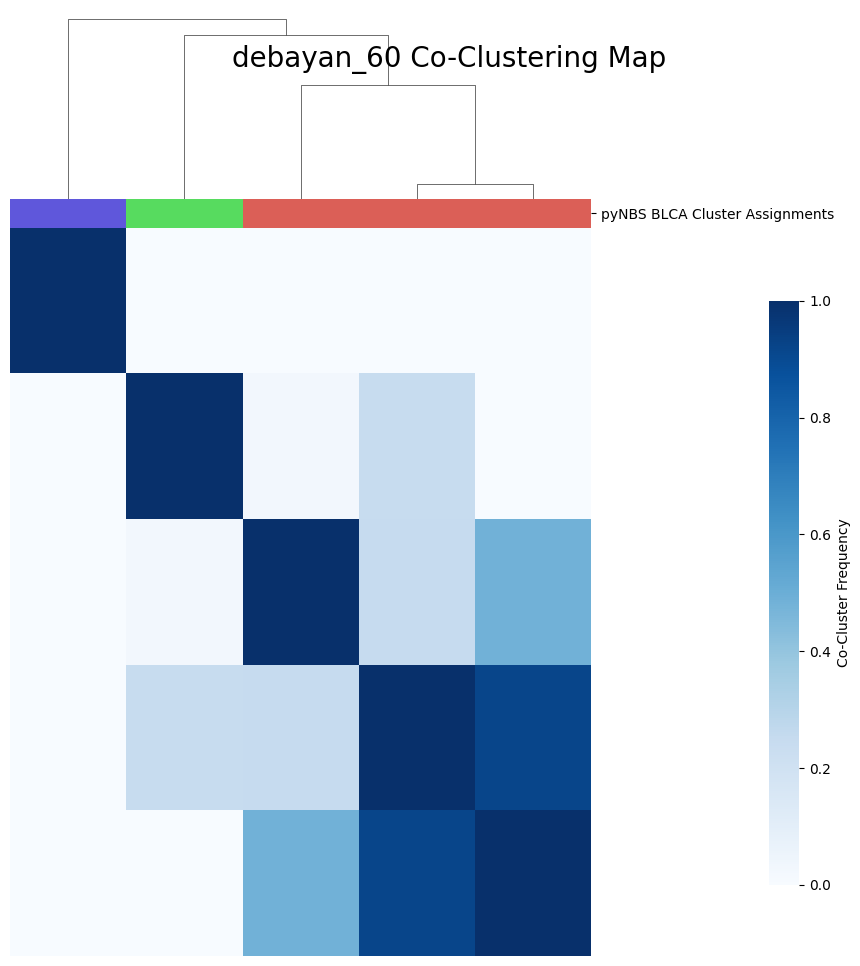

In [19]:
Image(filename = save_args['outdir']+save_args['job_name']+'_cc_map.png', width=600, height=600)